In [1]:
from datetime import datetime
from numpy import log, sqrt, exp, tanh
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import scipy.optimize as spo, scipy.interpolate as spi, scipy.stats as sps
from mpl_toolkits.mplot3d import Axes3D
# some configuration
import seaborn as sns; sns.set()
import os; os.chdir(r'C:\Users\54638\Desktop\Python\vol') # set path
import warnings; warnings.simplefilter('ignore')

In [ ]:
# bsm option pricer
def option_value(S, K, T, r, d, sigma):
    # eg. option_value(100, 100, 1, 0.05, 0.01, 0.25)
    d1 = (log(S / K) + (r - d + 0.5 * sigma ** 2)* T) / (sigma * sqrt(T))
    d2 = (log(S / K) + (r - d - 0.5 * sigma ** 2)* T) / (sigma * sqrt(T))
    v1 = S * exp(-d * T) * sps.norm.cdf(d1) - K * exp(-r * T) * sps.norm.cdf(d2)
    v2 = K * exp(-r * T) * sps.norm.cdf(-d2) - S * exp(-d * T) * sps.norm.cdf(-d1)
    return (v1, v2)

def option_vega(S, K, T, r, d, sigma):
    # eg. option_vega(100, 100, 1, 0.05, 0.01, 0.25)
    d1 = (log(S / K) + (r - d + 0.5 * sigma ** 2)* T) / (sigma * sqrt(T))
    return S * sqrt(T) * sps.norm.pdf(d1) * exp(-d * T)

def cal_vol(cp, S, K, T, r, d, price, maxiter = 100):
    # Newton scheme
    # cp: 0 means call, 1 means put
    # eg. cal_vol(0, 100, 100, 1, 0.05, 0.01, 11.7193)
    vol = 0.1
    for i in range(maxiter):
        diff = price - option_value(S, K, T, r, d, vol)[cp]
        vol = vol + diff / option_vega(S, K, T, r, d, vol)
    return vol

def find_vol(cp, S, K, T, r, d, price):
    # optimizor
    # cp: 0 means call, 1 means put
    # eg. find_vol(0, 100, 100, 1, 0.05, 0.01, 11.7193)
    vol = 0.1
    def target(vol): # need to put the variables in the front
        return abs(price - option_value(S, K, T, r, d, vol)[cp])
    res = spo.minimize(target, x0 = vol, method = 'SLSQP', tol = 1e-20) 
    # SLSQP 13.4ms, Nelder-Mead 34.3ms Powell 22.7ms, CG 26.3ms BFGS 81.9ms L-BFGS-B 54.2ms TNC 46.8ms COBYLA 23.4ms
    return res.x[0]

In [2]:
# basic data and some preparation
spxspot = 2917.52
spxdiv = 0.02
# import data
spxopt = pd.read_csv('spxvol.csv',index_col = 0, parse_dates = True)
usdfra = pd.read_csv('usdfra.csv',index_col = 0, parse_dates = True)
spxfwd = pd.read_csv('spxfwd.csv',index_col = 0, parse_dates = True)

rf = usdfra.Forward

## Observe the implied volatility

$K$ as x-axis

In [3]:
bdate = pd.bdate_range(datetime(2019,5,2), datetime(2022,5,30))
bdate_len = len(bdate)
bdate_series = pd.Series(range(bdate_len), index = bdate)
Yticks = [50,200,350,500,650]
Ylabels = bdate_series.iloc[[50,200,350,500,650]].index.strftime('%b-%y')

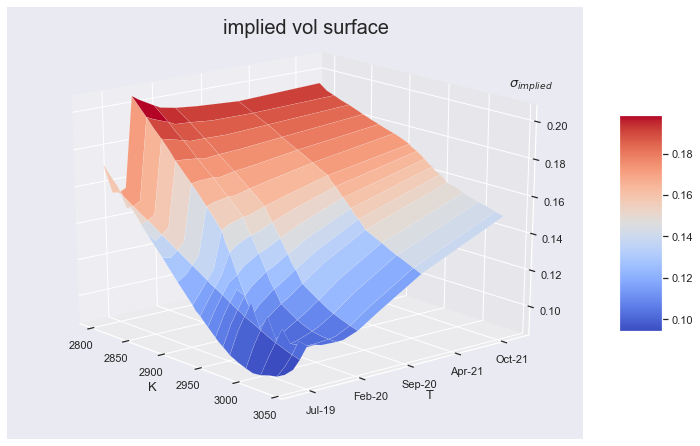

In [33]:
strikes = spxopt.columns.values.astype(int)
time = bdate_series[spxopt.index] # critical variable, change datetime to int
Z = spxopt.values
X, Y = np.meshgrid(strikes, time)


fig = plt.figure(figsize = (10,6))
ax = Axes3D(fig)
surf = ax.plot_surface(X,Y,Z, rstride = 2, cstride = 2,
                      cmap = 'coolwarm', linewidth = 0.1,
                      antialiased = True)
ax.set_xlabel('K', fontsize= 13)
ax.set_ylabel('T', fontsize= 13)
ax.text(3000, 800, 0.21, '$\sigma_{implied}$', zdir = (0,0,0), fontsize= 13)
# ax.set_zlabel('implied vol', fontsize= 13)
# ax.zaxis.set_rotate_label(0)
Yticks = [50,200,350,500,650]
Ylabels = bdate_series.iloc[[50,200,350,500,650]].index.strftime('%b-%y')
ax.set_yticks(Yticks)
ax.set_yticklabels(Ylabels)
ax.view_init(20,-40)
ax.text(2670, 670, 0.21, 'implied vol surface', zdir = (0,0,0), fontsize= 20)
fig.colorbar(surf, shrink = 0.5, aspect = 5)

## implied volatility surface 

$\sigma^2 = \alpha + \delta(\frac{tanh(Lx)}{L})+\gamma(\frac{tanh(Lx)}{L})^2,   x<0$

$\sigma^2 = \alpha + \delta(\frac{tanh(Rx)}{R})+\gamma(\frac{tanh(Rx)}{R})^2,   x>=0$

$ln(\frac{K}{F_T})$ as x-axis

In [7]:
def skew_curve(x, alpha, delta, gamma, L, R):
    tmp = np.where(x>=0,tanh(R * x)/R,tanh(L*x)/L)
    return alpha + delta * tmp + 0.5 * gamma * tmp

In [8]:
# find the parameters that fit the curve best
skew_para = pd.DataFrame([],index = ['alpha','delta','gamma','L','R'])
init = [0.1, -1, 3, -5, 6]
for date in spxopt.index:
    x = log(spxopt.columns.values.astype(int) / spxfwd.loc[date].values)
    y = spxopt.loc[date] ** 2
    rst = spo.curve_fit(skew_curve, x, y, init)[0]
    skew_para[date] = rst
# skew_para

In [12]:
# cache for skew_curve
xnum = 100
moneyness = np.linspace(-0.05,0.05,xnum)
time_len = len(time) # 12
skew_cache = np.zeros((time_len, xnum)) # 12*100
for i in range(time_len):
    date = time.index[i] # current date in datetime format
    alpha, delta, gamma, L, R = skew_para[date]
    skew_cache[i] = skew_curve(moneyness, alpha, delta, gamma, L, R)

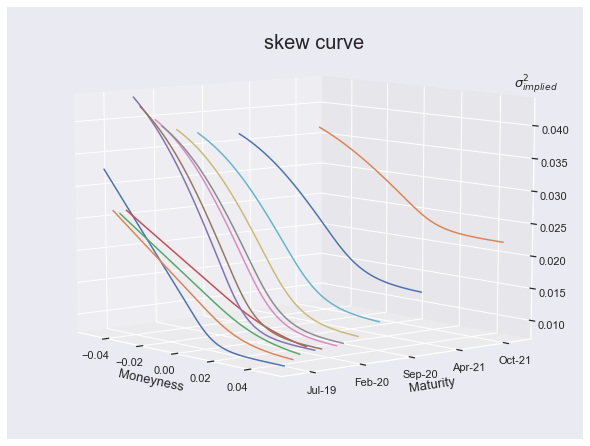

In [45]:
# plot skew_curve
fig = plt.figure(figsize = (8,6))
ax = Axes3D(fig)

for i in range(time_len):
    x = moneyness
    y = np.ones(xnum) * time.iloc[i] # current date in int format
    z = skew_cache[i]
    ax.plot(x,y,z)

ax.set_xlabel('Moneyness', fontsize= 13)
ax.set_ylabel('Maturity', fontsize= 13)
ax.text(0.056, 675, 0.046, '$\sigma^2_{implied}$', zdir = (0,0,0), fontsize= 13)
Yticks = [50,200,350,500,650]
Ylabels = bdate_series.iloc[[50,200,350,500,650]].index.strftime('%b-%y')
ax.set_yticks(Yticks)
ax.set_yticklabels(Ylabels)
ax.text(-0.04, 450, 0.05, 'skew curve', zdir = (0,0,0), fontsize= 20)
ax.view_init(10,-40)

In [46]:
# set the y axis limit
maturity = np.arange(min(time), max(time)) # 11-686
imp_vol = np.zeros((len(maturity),len(moneyness)))
for i in range(xnum):
    spline = spi.interp1d(time.values, skew_cache[:,i])
    imp_vol[:,i] = spline(maturity)
# imp_vol.shape

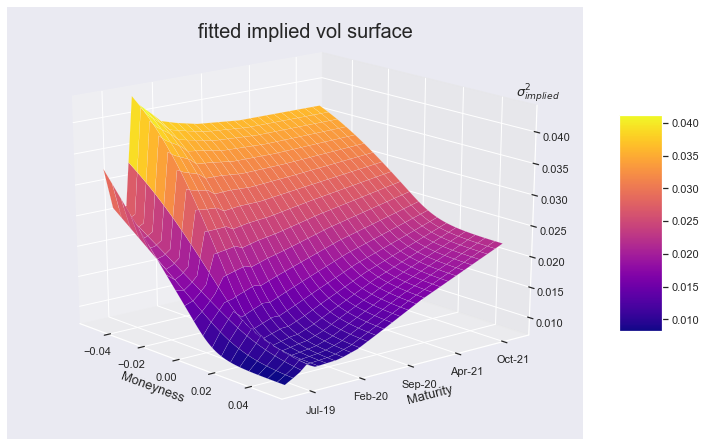

In [50]:
Z = imp_vol
X, Y = np.meshgrid(moneyness, maturity)

fig = plt.figure(figsize = (10,6))
ax = Axes3D(fig)
surf = ax.plot_surface(X,Y,Z, rstride = 25, cstride = 5,
                      cmap = 'plasma', linewidth = 0.1,
                      antialiased = True)
ax.set_xlabel('Moneyness', fontsize= 13)
ax.set_ylabel('Maturity', fontsize= 13)
ax.text(0.056, 675, 0.046, '$\sigma^2_{implied}$', zdir = (0,0,0), fontsize= 13)
Yticks = [50,200,350,500,650]
Ylabels = bdate_series.iloc[[50,200,350,500,650]].index.strftime('%b-%y')
ax.set_yticks(Yticks)
ax.set_yticklabels(Ylabels)
ax.view_init(20,-40)
ax.text(-0.04, 250, 0.052, 'fitted implied vol surface', zdir = (0,0,0), fontsize= 20)
fig.colorbar(surf, shrink = 0.5, aspect = 5)

## local volatility

### $y = ln(\frac{K}{F_T})$

### $w(S_0, K, T) = \sigma^2_{BS}(S_0, K, T)T $

## $ v_L = \frac{\frac{\partial w}{\partial T}} {1-\frac{y}{w}\frac{\partial w}{\partial y} +\frac{1}{4}(-\frac{1}{4}-\frac{1}{w}+\frac{y^2}{w^2})(\frac{\partial w}{\partial y})^2+\frac{1}{2}\frac{\partial^2 w}{\partial y^2}}$

In [51]:
fwd = spi.interp1d(time, spxfwd['Implied Fwd']) # construct a fwd function to retrieve data
total_vol = imp_vol.copy()
for i in range(len(maturity)):
    total_vol[i] = total_vol[i] * (i+min(time)) # transform to total_vol


In [52]:
def loc_vol(fun_fwd, strike, T):
    y = log(strike/fwd(T))
    
    # find dwdy
    fun_y = spi.splrep(moneyness, total_vol[T]/250) # moneyness不需要除以250，attune total_vol
    w1 = spi.splev(y, fun_y)
    dwdy = spi.splev(y, fun_y, der = 1)
    dwdy2 = spi.splev(y, fun_y, der = 2)
    
    # find dwdt
    tmp2 = np.zeros(time_len)
    for i in range(time_len):
        date = time.index[i]
        alpha, delta, gamma, L, R = skew_para[date]
        tmp2[i] = skew_curve(y, alpha, delta, gamma, L, R) * time.iloc[i] # transform to total_vol
    fun_t = spi.splrep(time, tmp2)
    w2 = spi.splev(T, fun_t) / 250
    dwdt = spi.splev(T, fun_t, der = 1)
    w = (w1 + w2) / 2

    v = dwdt / (1 - y/w*dwdy + 0.25*(-0.25 - 1/w + y**2/w**2) * dwdy**2 + 0.5*dwdy2)
    return sqrt(v) # sqrt(v)远远快于v**2

In [54]:
K = 2910
T = 50
loc_vol(fwd, K, T)

0.15087556738370492